# Prophet Forecast - Moving Window Solution

* Using Prophet for moving window solution.
* Prophet parameters: https://github.com/facebook/prophet/blob/master/python/fbprophet/forecaster.py

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# the logger here is to remove the warnings about plotly
import logging
logger = logging.getLogger('fbprophet.plot')
logger.setLevel(logging.CRITICAL)
from fbprophet import Prophet

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [11]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(100,) (100,) (14,) (10,)


purchase_date
2019-05-22         NaN
2019-05-23         NaN
2019-05-24         NaN
2019-05-25    3.748604
2019-05-26    3.671921
Name: client_count, dtype: float64

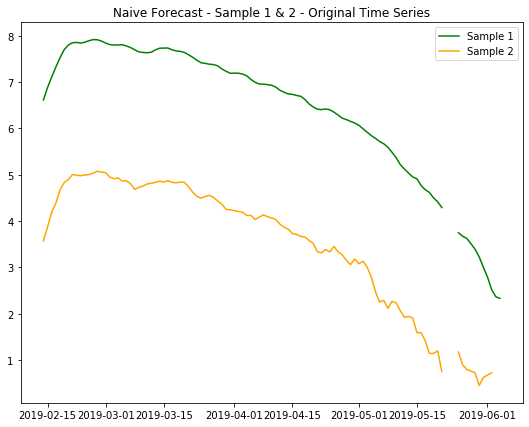

In [12]:
plt.figure(figsize=(9,7))
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Sample 1', color='green')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, color='green')
plt.plot(ts_moving_avg_train2.index, ts_moving_avg_train2, label='Sample 2', color='orange')
plt.plot(ts_moving_avg_test2.index, ts_moving_avg_test2, color='orange')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 & 2 - Original Time Series")
plt.show()

In [13]:
ts_ma_train1 = pd.DataFrame(ts_moving_avg_train1.copy())
ts_ma_train1['ds'] = ts_ma_train1.index
ts_ma_train1['y'] = ts_moving_avg_train1.values
ts_ma_train1.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_train1.shape)

ts_ma_test1 = pd.DataFrame(ts_moving_avg_test1.copy())
ts_ma_test1['ds'] = ts_ma_test1.index
ts_ma_test1['y'] = ts_moving_avg_test1.values
ts_ma_test1.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_test1.shape)

ts_ma_train2 = pd.DataFrame(ts_moving_avg_train2.copy())
ts_ma_train2['ds'] = ts_ma_train2.index
ts_ma_train2['y'] = ts_moving_avg_train2.values
ts_ma_train2.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_train2.shape)

ts_ma_test2 = pd.DataFrame(ts_moving_avg_test2.copy())
ts_ma_test2['ds'] = ts_ma_test2.index
ts_ma_test2['y'] = ts_moving_avg_test2.values
ts_ma_test2.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_test2.shape)

ts_ma_train1.head()

(100, 2)
(14, 2)
(100, 2)
(10, 2)


,ds,y
purchase_date,,
2019-02-11,2019-02-11,NaN
2019-02-12,2019-02-12,NaN
2019-02-13,2019-02-13,NaN
2019-02-14,2019-02-14,6.614372
2019-02-15,2019-02-15,6.883467


In [14]:
def geterate_train_test_sequences(all_ts, forecast_ts, train_period, test_period):
    """
    It divide a whole time series into multiple train-test sequences.
    
    @param all_ts: The whole time series. Its index is the date.
    @param forecast_ts: The final testing data.
    @param train_period: The number of days in the training data.
    @param test_period: The number of days in the testing data.
    @return: A dictionary where stores the index and each (train, test) pair.
    """
    seq_idx = 0
    train_test_dct = {}
    
    train_idx = 0
    
    while train_idx <= len(all_ts)-train_period-test_period:
        train_seq = all_ts[train_idx:train_idx+train_period]
        test_seq = all_ts[train_idx+train_period:train_idx+train_period+test_period]
        
        train_test_dct[seq_idx] = {'train': train_seq, 'test': test_seq}
        
        train_idx += test_period
        seq_idx += 1
        
    train_seq = all_ts[train_idx:]
    train_test_dct[seq_idx] = {'train': train_seq, 'test': forecast_ts}
        
    return train_test_dct

In [44]:
ts_ma1_train_test_dct = geterate_train_test_sequences(ts_ma_train1, ts_ma_test1, train_period=14, test_period=7)
ts_ma2_train_test_dct = geterate_train_test_sequences(ts_ma_train2, ts_ma_test2, train_period=14, test_period=7)

## Sample 1

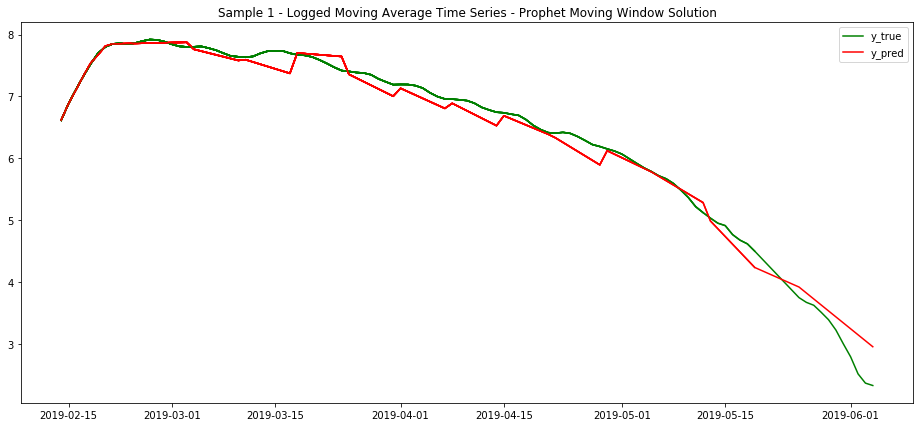

[0.0321, 0.0376, 0.1379, 0.0736, 0.0849, 0.0791, 0.0963, 0.0381, 0.1296, 0.0221, 0.0492, 0.1065, 0.2528]
historical average rmse 0.0739


In [66]:
all_true = None
all_forecast = None
rmse_lst = []

plt.figure(figsize=(16,7))

for seq_idx, train_test_pair in ts_ma1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    prophet_model = Prophet(daily_seasonality = True, yearly_seasonality=False, weekly_seasonality=False,
                            seasonality_mode = 'multiplicative', n_changepoints=5,
                            changepoint_prior_scale=0.05, seasonality_prior_scale=0.1)
    prophet_model.fit(train)
    
    periods = len(test.index)
    future = prophet_model.make_future_dataframe(periods=periods)
    forecast = prophet_model.predict(future)
    
    train = train.dropna()
    test = test.dropna()
    all_ts = train.append(test)
    forecast = forecast.loc[forecast['ds'].isin(all_ts.index)]
    
    if all_forecast is None:
        all_true = train.copy()
        all_true = all_true.append(test)
        all_forecast = forecast[['ds', 'yhat']].copy()
    else:
        all_true = all_true.append(test)
        all_forecast = all_forecast.append(forecast.loc[forecast['ds'].isin(test.index)][['ds', 'yhat']])
    
    plt.plot(all_true['ds'], all_true['y'], label='y_true', color='green')
    plt.plot(all_forecast['ds'], all_forecast['yhat'], label = 'y_pred', color='red')
    
    rmse = sqrt(mean_squared_error(all_ts['y'].values, forecast['yhat'].values))
    rmse_lst.append(round(rmse, 4))
    
    if seq_idx == 0:
        plt.legend(loc='best')
        
        
plt.title("Sample 1 - Logged Moving Average Time Series - Prophet Moving Window Solution")
plt.show()

print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

## Sample 2

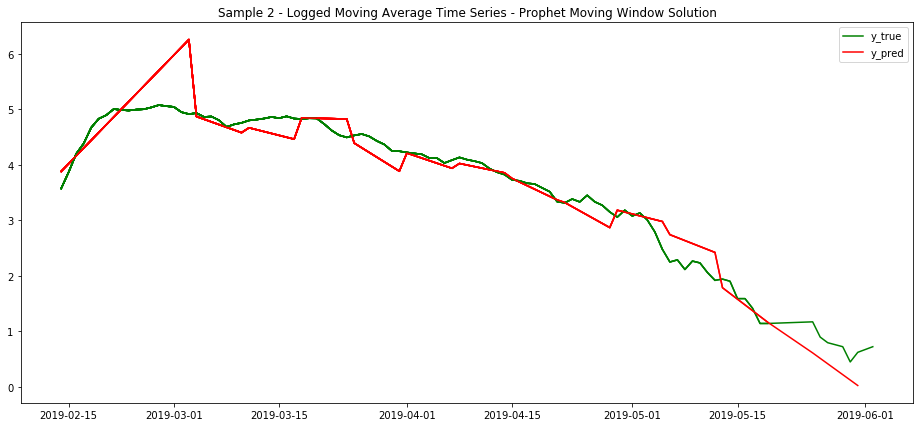

[0.5718, 0.0575, 0.1672, 0.1106, 0.1638, 0.062, 0.0499, 0.0415, 0.1496, 0.1341, 0.2684, 0.1361, 0.2716]
historical average rmse 0.1594


In [67]:
all_true = None
all_forecast = None
rmse_lst = []

plt.figure(figsize=(16,7))

for seq_idx, train_test_pair in ts_ma2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    prophet_model = Prophet(daily_seasonality = True, yearly_seasonality=False, weekly_seasonality=False,
                            seasonality_mode = 'multiplicative', n_changepoints=5,
                            changepoint_prior_scale=0.05, seasonality_prior_scale=0.1)
    prophet_model.fit(train)
    
    periods = len(test.index)
    future = prophet_model.make_future_dataframe(periods=periods)
    forecast = prophet_model.predict(future)
    
    train = train.dropna()
    test = test.dropna()
    all_ts = train.append(test)
    forecast = forecast.loc[forecast['ds'].isin(all_ts.index)]
    
    if all_forecast is None:
        all_true = train.copy()
        all_true = all_true.append(test)
        all_forecast = forecast[['ds', 'yhat']].copy()
    else:
        all_true = all_true.append(test)
        all_forecast = all_forecast.append(forecast.loc[forecast['ds'].isin(test.index)][['ds', 'yhat']])
    
    plt.plot(all_true['ds'], all_true['y'], label='y_true', color='green')
    plt.plot(all_forecast['ds'], all_forecast['yhat'], label = 'y_pred', color='red')
    
    rmse = sqrt(mean_squared_error(all_ts.loc[all_ts['ds'].isin(forecast['ds'].values)]['y'].values, forecast['yhat'].values))
    rmse_lst.append(round(rmse, 4))
    
    if seq_idx == 0:
        plt.legend(loc='best')
        
        
plt.title("Sample 2 - Logged Moving Average Time Series - Prophet Moving Window Solution")
plt.show()

print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

## Summary

* With moving window solution, each training set is small, and when using Prophet, `changepoint_prior_scale` and `seasonality_prior_scale` better to be smaller, but doesn't mean smaller `n_changepoints` is better.
* Obviously, when using moving window & Prophet, the overall results are better than fixed window and other moving window solutions, for both samples, for both historical average RMSE and forecasting RMSE. Here, I even haven't used param tuning yet.
* Comparing with moving window solution in Holt Winters, this method could take a bit longer time. However, in real life application, we don't calculate all the previous moving windows, they are majorly used for param tuning. So should be fine.